2부 지도학습 알고리즘  
5장 패널티 회귀와 최소 분산 포트폴리오를 위한 희소 헤징

In [5]:
import pandas as pd
import numpy as np
data_raw = pd.read_csv('data_ml.csv')
idx_date = data_raw.index[(
    data_raw['date'] > '1999-12-31') & (
    data_raw['date'] < '2019-01-01')].tolist()
#날짜를 받기 위한 인덱스 생성
data_ml = data_raw.iloc[idx_date]
#날짜 인덱스에 따라 데이터셋 필터링
data_ml.iloc[0:6, 0:6]

features = list(data_ml.iloc[:, 3:95].columns)
# 특성의 열 이름 저장 
features_short = ["Div_Yld", "Eps", "Mkt_Cap_12M_Usd",
                  "Mom_11M_Usd", "Ocf", "Pb", "Vol1Y_Usd"]

라쏘 회귀

In [6]:
from sklearn.linear_model import Lasso, Ridge, ElasticNet
y_penalized = data_ml['R1M_Usd'].values
X_penalized = data_ml[features].values
alphas = np.arange(1e-4, 1.0e-3, 1e-5)
lasso_res = {}

<Axes: xlabel='Lambda', ylabel='Beta'>

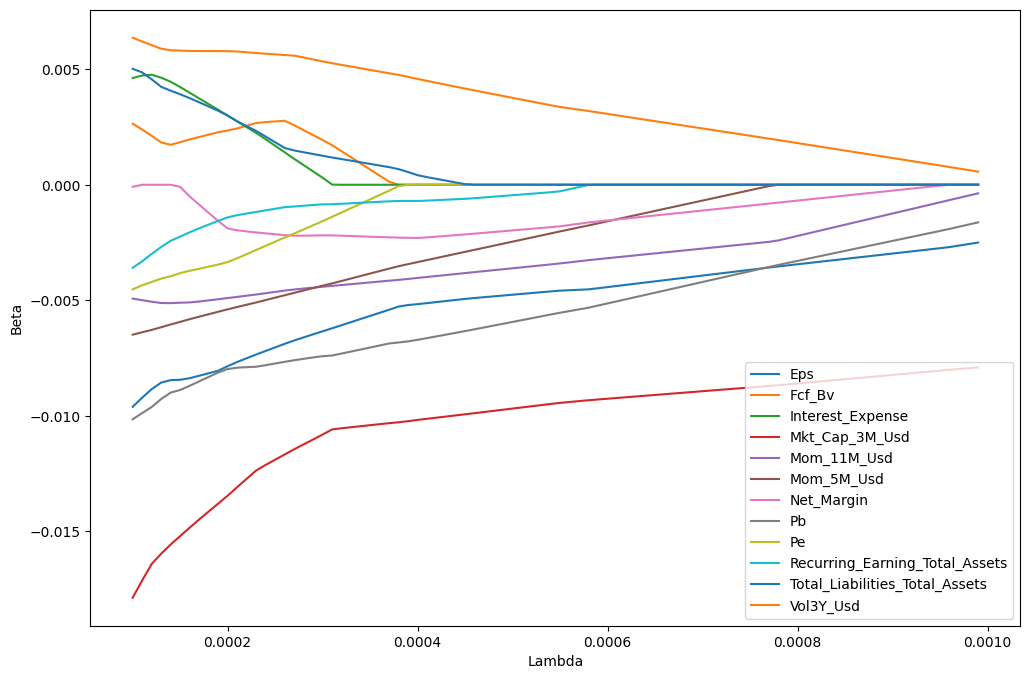

In [7]:
for alpha in alphas:
    lasso = Lasso(alpha=alpha)
    lasso.fit(X_penalized, y_penalized)
    lasso_res[alpha] = lasso.coef_

df_lasso_res = pd.DataFrame.from_dict(lasso_res).T
df_lasso_res.columns = features
predictors = (df_lasso_res.abs().sum() > 0.05) # 신뢰도 높은 예측 인자 선택
df_lasso_res.loc[:, predictors].plot(
    xlabel='Lambda', ylabel='Beta', figsize=(12,8)
)

릿지 회귀

<Axes: xlabel='Lambda', ylabel='Beta'>

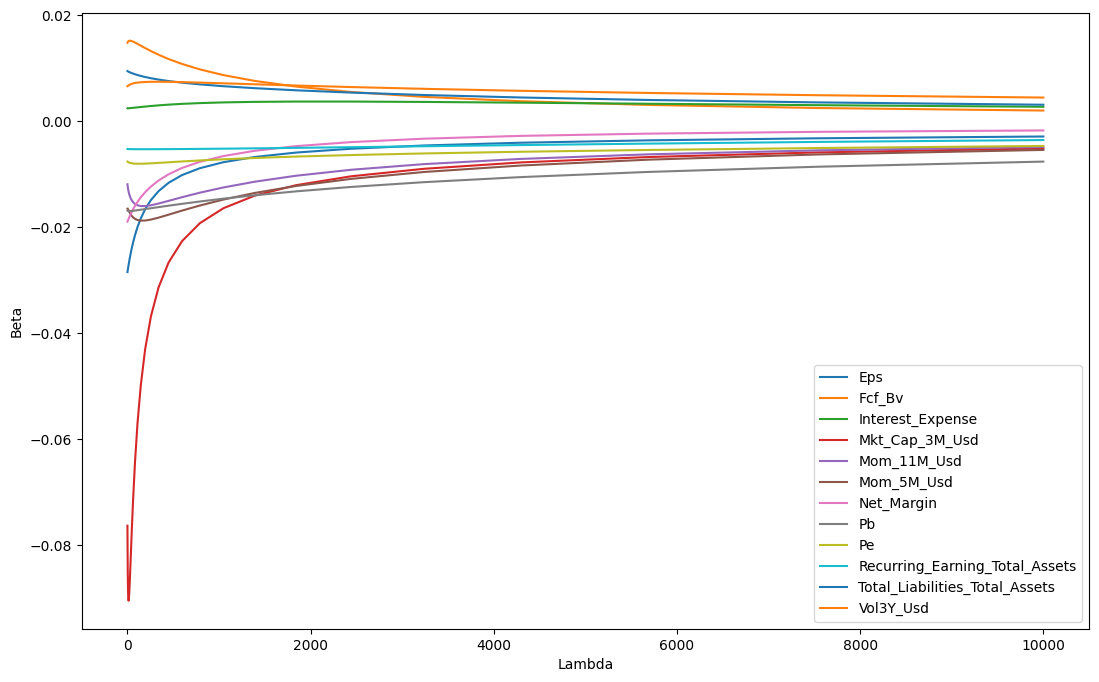

In [8]:
n_alphas = 50
alphas = np.logspace(-2, 4, n_alphas)

#Aspect Ratio 를 위한 로그 변환
ridge_res = {}
for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_penalized, y_penalized)
    ridge_res[alpha] = ridge.coef_
df_ridge_res = pd.DataFrame.from_dict(ridge_res).T
df_ridge_res.columns = features
df_ridge_res.loc[:,predictors].plot(
    xlabel='Lambda', ylabel='Beta', figsize=(13,8)
)

희소 헤징 포트폴리오

In [9]:
stock_ids_short = []
stock_days = []
separation_date = "2014-01-15"
idx_train = data_ml.index[(data_ml['date']<separation_date)].tolist()
idx_test = data_ml.index[(data_ml['date']>=separation_date)].tolist()

# 각 주식별 데이터 포인트 개수 세기
stock_ids = data_ml['stock_id'].unique()
stock_days = data_ml[['date', 'stock_id']].groupby(
    ['stock_id']).count().reset_index()

# 데이터가 모두 있는 주식을 리스트로 변환
stock_ids_short = stock_days.loc[
    stock_days['date'] == (stock_days['date'].max())]
stock_ids_short = stock_ids_short['stock_id'].unique()
is_stock_ids_short = data_ml['stock_id'].isin(stock_ids_short)
returns = data_ml[is_stock_ids_short].pivot(
    index='date', columns='stock_id', values='R1M_Usd'
)

In [10]:
t_oos = returns.index[returns.index>separation_date].values
Tt = len(t_oos) # 날짜 개수
nb_port = 3 # 포트폴리오/전략 개수
port_weights = {}
port_returns = {}

희소 헤징 포트폴리오의 가중치 따로 분리

In [11]:
def weights_sparsehedge(returns, alpha, Lambda):
    weights = []
    lr = ElasticNet(alpha=alpha, l1_ratio=Lambda)
    for col in returns.columns:
        y = returns[col].values
        X = returns.drop(col, axis=1).values
        lr.fit(X,y)
        err = y - lr.predict(X)
        w = (1 - np.sum(lr.coef_)) /  np.var(err)
        weights.append(w)
    return weights / np.sum(weights)

EW 벤치마크, 고전적 GMV, 희소 헤징 최소 분산 을 모두 포함하는 메타 가중 함수 정의 (놀라움)

In [12]:
def weights_multi(returns, j , alpha, Lambda):
    N = returns.shape[1]
    if j == 0: # 동일 가중 (EW)
        return np.repeat(1/N, N)
    elif j == 1: # 최소 분산 GMV
        sigma = np.cov(returns.T) + 1e-2 * np.identity(N) #공분산 행렬 + 규제 항
        w = np.matmul(np.linalg.inv(sigma), np.repeat(1,N)) #행렬 곱과 역행렬 계산
        return w/ np.sum(w)
    elif j == 2: #규제화 / 엘라스틱넷
        return weights_sparsehedge(returns, alpha, Lambda)

백테스팅 루프문

In [13]:
for m, month in np.ndenumerate(t_oos): #루프 = 리벨런싱 날짜
    temp_data = returns.loc[returns.index < month]
    realised_returns = returns.loc[returns.index == month].values
    weights_temp = {}
    returns_temp = {}
    
    for j in range(nb_port):
        wgts = weights_multi(temp_data, j , 0.1, 0.1)
        rets = np.sum(wgts * realised_returns)
        weights_temp[j] = wgts
        returns_temp[j] = rets
        
    port_weights[month] = weights_temp
    port_returns[month] = returns_temp
    
port_returns_final = pd.concat(
    {k : pd.DataFrame.from_dict(v, 'index') for k, v in port_returns.items()}, axis = 0
).reset_index()

# 딕셔너리 컴프리헨션
colnames = ['date', 'strategy', 'return']
port_returns_final.columns = colnames
strategies_name = {0:'EW', 1:'MV', 2:'Sparse'}
port_returns_final['strategy'] = port_returns_final['strategy'].replace(strategies_name)
pd.DataFrame(port_returns_final.groupby('strategy')['return'].std()).T

strategy,EW,MV,Sparse
return,0.041804,0.033504,0.034882


In [14]:
training_sample = data_ml[data_ml.index.isin(idx_train)]
testing_sample = data_ml[data_ml.index.isin(idx_test)]

y_penalized_train = training_sample['R1M_Usd'].values
X_penalized_train = training_sample[features].values
model = ElasticNet(alpha=0.1, l1_ratio=0.1)
fit_pen_pred = model.fit(X_penalized_train, y_penalized_train)

In [15]:
y_penalized_test = testing_sample['R1M_Usd'].values
X_penalized_test = testing_sample[features].values
mse = np.mean((fit_pen_pred.predict(X_penalized_test) - y_penalized_test) **2)
print(f'MSE: {mse}')

MSE: 0.036996958091850045


In [16]:
hitratio = np.mean(fit_pen_pred.predict(X_penalized_test) * y_penalized_test > 0)
print(f'Hit Ratio: {hitratio}')

Hit Ratio: 0.5460346399270738


5.4 코딩 예제  
테스트 샘플상에서 두 엘라스틱 넷의 매개변수가 표본 외 정확도에 미치는 영향을 평가하라.

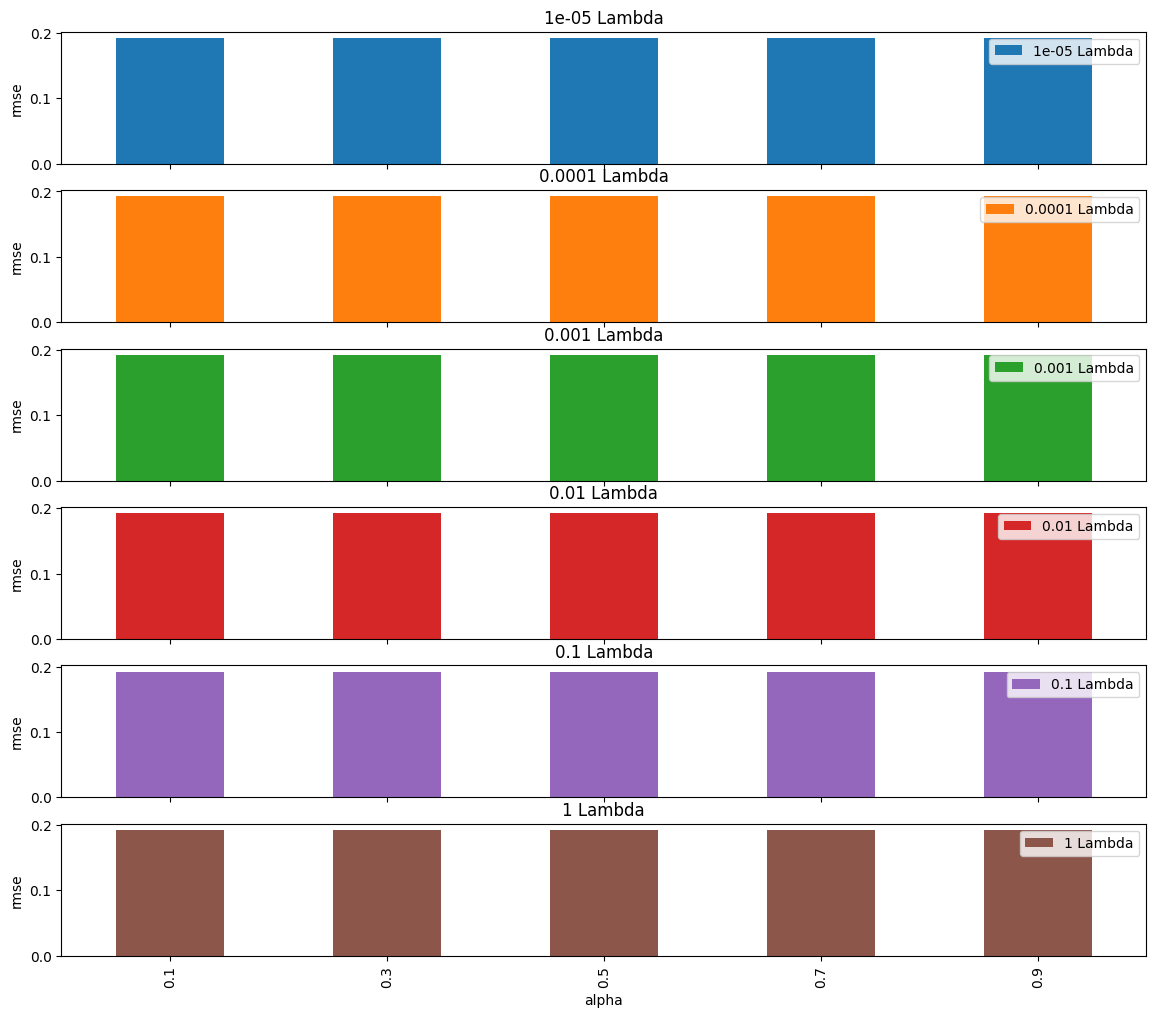

In [20]:
import itertools
import matplotlib.pyplot as plt
y_penalized_train = training_sample['R1M_Usd'].values
X_penalized_train = training_sample[features].values
y_penalized_test = testing_sample['R1M_Usd'].values
X_penalized_test = testing_sample[features].values

lasso_sens = []
alpha_seq = list(np.round(np.arange(0.1,1.1,0.2), 2))
lambda_seq = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]

for i,j in itertools.product(alpha_seq, lambda_seq):
    model = ElasticNet(alpha=i, l1_ratio=j)
    fit_temp = model.fit(X_penalized_train, y_penalized_train)
    rmse = np.sqrt( np.mean((fit_temp.predict(X_penalized_test) - y_penalized_test) ** 2))
    lasso_sens.append([rmse,i,j])
    
lasso_sens = pd.DataFrame(lasso_sens, columns=['rmse', 'alpha', 'lambda'])
rmse_elas = lasso_sens.pivot(index='alpha', columns='lambda', values='rmse')

new_col_names = list(map(lambda x: str(x) + str(" Lambda"), lambda_seq))
rmse_elas.columns = new_col_names
rmse_elas.plot(
    figsize = (14,12),
    subplots= True, sharey= True, sharex=True, kind='bar', ylabel='rmse')
plt.show()